# License Status Prediction - Multiclass Classification
<hr style="border:1px solid gray"> </hr>

## Contents.

    1. Problem Description
    2. Data Exploration
    3. Feature Selection
    4. KNN Algorithm
    5. Naive Bias
    5. Logistic Regression
    6. Decisoin Tree
    
--------------------------------------------------------------------------------------------------------------------------------


### Problem Description

We are given a license dataset which holds various information related the business license , The objective of out problem is to predict license Status for the given business. Lets start with delving deep into the data.
________________________________________________________________________________________________________________________________

In [ ]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import category_encoders as ce

In [3]:
# read the df
df = pd.read_csv("License_data.csv")

# print the shape of the dataframe
print(df.shape)

# show the top few rows
display(df.head().T)

(85895, 32)


C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,0,1,2,3,4
ID,35342-20020816,1358463-20051116,1980233-20090722,1476582-20040211,1141408-20080516
LICENSE ID,1256593,1639294,1980233,1476582,1896750
ACCOUNT NUMBER,32811,262311,345008,273121,213785
SITE NUMBER,1,29,1,1,1
LEGAL NAME,CARMEN CAHUE,"ISLA TROPICAL, INC.",DJS REMODELING,ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
DOING BUSINESS AS NAME,CLAUDIA'S BRIDAL SHOP,ISLA TROPICAL,"DJS REMODELING, INC.",ALL-BRY CONSTRUCTION CO.,MCDONOUGH MECHANICAL SERVICE
ADDRESS,2625 S CENTRAL PARK AVE 1,2825 W MONTROSE AVE,1605 CLAVEY RD 1,8 NORTH TRAIL,4081 JOSEPH DR
CITY,CHICAGO,CHICAGO,HIGHLAND,LEMONT,WAUKEGAN
STATE,IL,IL,IL,IL,IL
ZIP CODE,60623.0,60618,60035,60439,60087


In [4]:
# change the columns name
new_col_name = [col.replace(" ","_").lower() for col in df.columns]
df.columns = new_col_name

## Variable Description

<b>Dependent Variable</b>   <br>
&nbsp;&nbsp;&nbsp;&nbsp;    1. AAI - License status is issued <br>
&nbsp;&nbsp;&nbsp;&nbsp;    2. AAC - License status is cancelled <br>
&nbsp;&nbsp;&nbsp;&nbsp;    3. REV - License status is revoked <br>
&nbsp;&nbsp;&nbsp;&nbsp;    4. REA - License status is revoked and appealed <br>
&nbsp;&nbsp;&nbsp;&nbsp;    5. INQ - License status is in enquiry <br>
    <br>
<b>Independent Variable</b> : <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Timeline of the application status <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Type of business <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Location details of the business <br>
&nbsp;&nbsp;&nbsp;&nbsp;    Payment details <br>
_______________________________________________________________________________________________________________________________

In [5]:
df.columns

Index(['id', 'license_id', 'account_number', 'site_number', 'legal_name',
       'doing_business_as_name', 'address', 'city', 'state', 'zip_code',
       'ward', 'precinct', 'ward_precinct', 'police_district', 'license_code',
       'license_description', 'license_number', 'application_type',
       'application_created_date', 'application_requirements_complete',
       'payment_date', 'conditional_approval', 'license_term_start_date',
       'license_term_expiration_date', 'license_approved_for_issuance',
       'date_issued', 'license_status_change_date', 'ssa', 'latitude',
       'longitude', 'location', 'license_status'],
      dtype='object')

## Data Cleansing

1. Missing Values - lot of missing data for particular variables
2. Unique Data - id (no meaning)
3. Data leakage - The AAI alone doesn't have licesnse status change value (as the license are never revoked/cancelled) 


In [6]:
df.isnull().sum()

id                                       0
license_id                               0
account_number                           0
site_number                              0
legal_name                               0
doing_business_as_name                   1
address                                  0
city                                     0
state                                    0
zip_code                                31
ward                                 49701
precinct                             56701
ward_precinct                        49700
police_district                      54012
license_code                             0
license_description                      0
license_number                           1
application_type                         0
application_created_date             64660
application_requirements_complete      214
payment_date                          1289
conditional_approval                     0
license_term_start_date                228
license_ter

In [7]:
# Drop columns which are not relevent for the prediction / too many missing values
drop_col_list = ["id","license_id","ssa","location","application_created_date","account_number","address"]
df = df.drop(drop_col_list, axis=1)

In [8]:
df["license_status_change"] = np.where(df.license_status_change_date.isnull(),1,0)

In [9]:
pd.crosstab(df.license_status_change,df.license_status)

license_status,AAC,AAI,INQ,REA,REV
license_status_change,,,,,
0,30200,0,2,3,290
1,0,55400,0,0,0


## Data Transformation
1. Timeline creation
2. Encoding
3. New Feature

In [10]:
# convert string object into date
df.application_requirements_complete = pd.DatetimeIndex(df.application_requirements_complete)
df.payment_date = pd.DatetimeIndex(df.payment_date)
df.license_term_start_date = pd.DatetimeIndex(df.license_term_start_date)
df.license_term_expiration_date = pd.DatetimeIndex(df.license_term_expiration_date)
df.license_approved_for_issuance = pd.DatetimeIndex(df.license_approved_for_issuance)
df.date_issued = pd.DatetimeIndex(df.date_issued)

In [11]:
# Find no.of days btw different application status date
df["completion_to_start"] = (df.license_term_start_date - df.application_requirements_complete).dt.days
df["start_to_expiry"] =  (df.license_term_expiration_date - df.license_term_start_date).dt.days
df["approval_to_issuance"] = (df.date_issued - df.license_approved_for_issuance).dt.days
df["completion_to_payment"] = (df.payment_date - df.application_requirements_complete).dt.days

df["presence_of_enquiry_details"] = np.where(df.ward.isnull() | df.ward_precinct.isnull() | df.police_district | df.precinct , 0 ,1 )

df["target"] = df[['license_status']].apply(lambda col:pd.Categorical(col).codes)

In [12]:
df.city.unique()

array(['CHICAGO', 'HIGHLAND', 'LEMONT', ..., 'ABERDEEN', 'PENSACOLA',
       'MACHESNEY PARK'], dtype=object)

In [55]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))
print(y_onehot.columns)

Index(['target_1', 'target_2', 'target_3', 'target_4', 'target_5'], dtype='object')


C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Target Encoding

In [14]:
enc=ce.OneHotEncoder().fit(df.target.astype(str))
y_onehot=enc.transform(df.target.astype(str))

class_names=y_onehot.columns
for class_ in class_names:
  enc=ce.TargetEncoder(smoothing=0)
  temp = enc.fit_transform(df[["license_description","state","city"]],y_onehot[class_])
  temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
  df = pd.concat([df,temp],axis=1)

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categor

### Class Imbalance 

In [15]:
df.license_status.value_counts()

AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: license_status, dtype: int64

In [16]:
df.license_status.value_counts(normalize=True).mul(100).round(3).astype(str) + '%'

AAI    64.497%
AAC    35.159%
REV     0.338%
REA     0.003%
INQ     0.002%
Name: license_status, dtype: object

## over sampling/under sampling

In [52]:
np.sort(df.target.unique()).tolist()

[0, 1, 2, 3, 4]

In [17]:
# Undersampling
df_0 = df[df.target==0].sample(frac=0.3,replace=False)
df_1 = df[df.target==1].sample(frac=0.3,replace=False)
# oversamplig
df_2 = df[df.target==2].sample(frac=200,replace=True)
df_3 = df[df.target==3].sample(frac=100,replace=True)
df_4 = df[df.target==4].sample(frac=2,replace=True)

sampled_df = pd.concat([df_0,df_1,df_2,df_3,df_4])

sampled_df.target.value_counts()

1    16620
0     9060
4      580
2      400
3      300
Name: target, dtype: int64

## Train / Test Data Preparation

In [18]:
X = sampled_df[['latitude', 'longitude',
       'completion_to_start',
       'start_to_expiry', 'approval_to_issuance', 'completion_to_payment',
       'presence_of_enquiry_details',  'license_description_target_1',
       'state_target_1', 'city_target_1', 'license_description_target_2',
       'state_target_2', 'city_target_2', 'license_description_target_3',
       'state_target_3', 'city_target_3', 'license_description_target_4',
       'state_target_4', 'city_target_4', 'license_description_target_5',
       'state_target_5', 'city_target_5']]

y = sampled_df['target']

In [19]:
# mean imputation
X = X.fillna(X.mean())

In [20]:
# Train/test preparation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

## Modeling

In [21]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

In [22]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
knn_model.fit((scaler.transform(X_train)),y_train)
scaler.fit(X_test)
y_pred = knn_model.predict(scaler.transform(X_test))

In [23]:
# Metrics Performance
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.52      0.63       906
           1       0.78      0.95      0.86      1667
           2       0.00      0.00      0.00        35
           3       1.00      0.74      0.85        34
           4       0.49      0.46      0.48        54

    accuracy                           0.78      2696
   macro avg       0.62      0.53      0.56      2696
weighted avg       0.77      0.78      0.76      2696



C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

C:\Users\Stanley\anaconda3\envs\projectpro\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.42      0.53       906
           1       0.74      0.95      0.83      1667
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00        34
           4       0.00      0.00      0.00        54

    accuracy                           0.73      2696
   macro avg       0.29      0.27      0.27      2696
weighted avg       0.70      0.73      0.69      2696



In [26]:
# Metrics Performance
print(confusion_matrix(y_test,y_pred))

[[ 384  519    3    0    0]
 [  74 1581    5    6    1]
 [   0   35    0    0    0]
 [  34    0    0    0    0]
 [  44   10    0    0    0]]


In [29]:
# Naive Bias
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
y_pred = nb_model.fit(X_train, y_train).predict(X_test)

In [30]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.38      0.48       906
           1       0.91      0.83      0.87      1667
           2       1.00      1.00      1.00        35
           3       0.30      1.00      0.46        34
           4       0.08      0.74      0.15        54

    accuracy                           0.68      2696
   macro avg       0.58      0.79      0.59      2696
weighted avg       0.79      0.68      0.72      2696



In [31]:
print(confusion_matrix(y_test,y_pred))

[[ 343  145    0   70  348]
 [ 185 1386    0    5   91]
 [   0    0   35    0    0]
 [   0    0    0   34    0]
 [   8    0    0    6   40]]


In [32]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=0)
y_pred = dt_model.fit(X_train, y_train).predict(X_test)

In [33]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier()

DecisionTreeClassifier()

In [34]:
# Metrics Performance
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       906
           1       0.88      0.90      0.89      1667
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        34
           4       0.75      0.93      0.83        54

    accuracy                           0.86      2696
   macro avg       0.89      0.92      0.90      2696
weighted avg       0.86      0.86      0.86      2696



In [35]:
print(confusion_matrix(y_test,y_pred))

[[ 694  197    0    0   15]
 [ 162 1503    0    0    2]
 [   0    0   35    0    0]
 [   0    0    0   34    0]
 [   4    0    0    0   50]]


In [36]:
# Finding the variable with more importance
feature_importance = pd.DataFrame([X_train.columns, dt_model.feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[1:10]

No handles with labels found to put in legend.


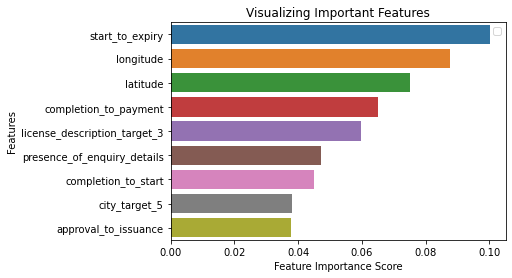

In [37]:
import seaborn as sns
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
# Hyperparameter Tuning - Tree parameters
1. No. of trees
2. Depth of the trees
3. Min no. of samples in the leaf node
4. Max number of features
5. Split Criterion 